## Neural networks for segmentation

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
# Путь до диска
DISK_PATH = "drive/MyDrive"
# Путь до архива с данными
ZIP_PATH = "drive/MyDrive/DS/data.zip"
# Путь для папки с данными
DATA_PATH = "drive/MyDrive/hw3data"

In [3]:
# ! unzip $ZIP_PATH -d  $DATA_PATH

Our task is to train neural network to segment cells edges.

Here is an example of input data with corresponding ground truth:

In [4]:
from albumentations import RandomSizedCrop
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import PIL.Image as Image
import scipy as sp
import scipy.misc
import scipy.stats as sps
import seaborn as sns
import skimage
import skimage.io
import torch
import torch.nn.functional as F
from IPython import get_ipython
from PIL import Image as Image
from torch.autograd import Variable
from torch.utils.data import Dataset
from torchvision import datasets, transforms
from tqdm import tqdm_notebook

import glob
import os
import pickle
import time
import warnings

%matplotlib inline

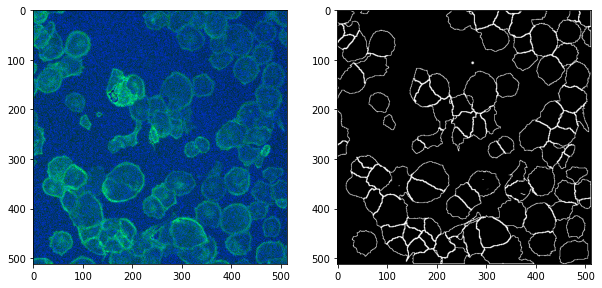

In [5]:
# Human HT29 colon-cancer cells
plt.figure(figsize=(10,8))
plt.subplot(1,2,1)
im = skimage.img_as_ubyte(skimage.io.imread(DATA_PATH + '/BBBC018_v1_images-fixed/train/00735-actin.DIB.bmp'))
plt.imshow(im)
plt.subplot(1,2,2)
mask = skimage.img_as_ubyte(skimage.io.imread(DATA_PATH + '/BBBC018_v1_outlines/train/00735-cells.png'))
plt.imshow(mask, 'gray')

In [6]:
device = f"cuda" if torch.cuda.is_available() else "cpu"

We train neural network to predict mask of edge pixels (pixels in gt images with value greater than 0).

In [7]:
def calc_iou(prediction, ground_truth):
    n_images = len(prediction)
    intersection, union = 0, 0
    for i in range(n_images):
        intersection += np.logical_and(prediction[i] > 0, ground_truth[i] > 0).astype(np.float32).sum() 
        union += np.logical_or(prediction[i] > 0, ground_truth[i] > 0).astype(np.float32).sum()
    return float(intersection) / union

*Using [model for brain segmentation](https://github.com/mateuszbuda/brain-segmentation-pytorch)*.

In [9]:
model = torch.hub.load('mateuszbuda/brain-segmentation-pytorch', 'unet',
    in_channels=3, out_channels=1, init_features=32, pretrained=True).cuda(device)

Downloading: "https://github.com/mateuszbuda/brain-segmentation-pytorch/archive/master.zip" to /root/.cache/torch/hub/master.zip
Downloading: "https://github.com/mateuszbuda/brain-segmentation-pytorch/releases/download/v1.0/unet-e012d006.pt" to /root/.cache/torch/hub/checkpoints/unet-e012d006.pt


Credits to: [Lung segmentation](https://github.com/IlliaOvcharenko/lung-segmentation)

In [15]:
class CellsDataset(Dataset):

    def __init__(self, images_folder, masks_folder=None, transform=None):
        '''
        images_folder: path to images (dataset itself)
        masks_folder: path to masks
        transform: augmentation or its composition
        '''
        super().__init__
        
        # Folder initialization
        self.images_folder = images_folder
        self.masks_folder = masks_folder
        
        self.img_files = sorted(glob.glob(
            os.path.join(images_folder, '*-actin.DIB.bmp')))
        
        self.mask_files = []
        if self.masks_folder is None:
            return
        
        for img_path in self.img_files:
            self.mask_files.append(
                os.path.join(masks_folder,
                             os.path.basename(img_path)[:5] + '-cells.png'))
        self.mask_files = sorted(self.mask_files)

        self.transform = transform
    
    def __getitem__(self, index):
        img_path = self.img_files[index]
        data = skimage.io.imread(img_path)
        
        if self.masks_folder is None:
            data = np.transpose(data, [2, 0, 1])
            return torch.FloatTensor(data) / 255.
        
        mask_path = self.mask_files[index]
        label = skimage.io.imread(mask_path)
        
        if self.transform is not None:
            augmented = self.transform(image=data, mask=label)
            data = augmented['image']
            label = augmented['mask']
            
        data = np.transpose(data, [2, 0, 1])
        
        return torch.FloatTensor(data) / 255., \
               torch.FloatTensor(label).unsqueeze(0) / 255.

    def __len__(self):
        return len(self.img_files)


def calculate_mean_std(dataset):
    image_means = torch.stack([t.reshape(-1, 3).mean(0) for t, c in dataset])
    image_means = image_means.mean(0)

    image_stds = torch.stack([t.reshape(-1, 3).std(0) for t, c in dataset])
    image_stds = image_stds.mean(0)

    return image_means, image_stds

*Using data augmentation since train set consists of just 41 images.*

In [22]:
transform_train_val = RandomSizedCrop(p=1, min_max_height=(128, 256),
                                      height=256, width=256)

In [23]:
# Optimizer
opt = torch.optim.Adam(model.parameters(), lr=0.001)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(opt, patience=6, verbose=True)

In [24]:
IMAGES_PATH = DATA_PATH + '/BBBC018_v1_images-fixed/'
OUTLINES_PATH = DATA_PATH + '/BBBC018_v1_outlines/'

train_data = CellsDataset(IMAGES_PATH + 'train', OUTLINES_PATH + 'train',
                       transform=transform_train_val)
val_data = CellsDataset(IMAGES_PATH + 'val', OUTLINES_PATH + 'val',
                     transform=transform_train_val)
test_data = CellsDataset(IMAGES_PATH + 'test')

In [25]:
batch_size = 16

train_batch_gen = torch.utils.data.DataLoader(train_data,
                                              batch_size=batch_size,
                                              shuffle=True,
                                              num_workers=4)
val_batch_gen = torch.utils.data.DataLoader(val_data,
                                            batch_size=batch_size,
                                            shuffle=True,
                                            num_workers=4)

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:477: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


In [26]:
def loss(model, X, y):
    X = Variable(torch.FloatTensor(X)).cuda(device)
    y = torch.FloatTensor(y).cuda(device)
    preds = model(X)
    
    assert preds.shape == y.shape, f"{preds.shape} != {y.shape}"
    return F.binary_cross_entropy(preds, y)

In [30]:
def train(model, train_batch_gen, train_loss):
    model.train(True)
    for (X_batch, y_batch) in train_batch_gen:
        opt.zero_grad()
        l = loss(model, X_batch, y_batch)
        l.backward()
        opt.step()
        train_loss.append(l.data.cpu().numpy())

def validate(model, val_batch_gen, val_iou):
    model.train(False)
    with torch.no_grad():
        for X_batch, y_batch in val_batch_gen:
            logits = model(Variable(torch.FloatTensor(X_batch)).cuda(device)).data.cpu()
            val_iou.append(calc_iou((logits > 0.15).cpu().numpy(), y_batch.cpu().numpy()))

In [31]:
MODELS_PATH = DATA_PATH + '/models/'
MODELS_PATH

'drive/MyDrive/hw3data/models/'

In [32]:
train_loss = []
val_iou = []
to_save = []

In [33]:
# Train loop
num_epochs = 100
save_by_epoch = 10

experiment_number = 3

for epoch in range(1, num_epochs + 1):
    start_time = time.time()
    
    train(model, train_batch_gen, train_loss)

    validate(model, val_batch_gen, val_iou)

    print("Epoch {} of {} took {:.3f}s".format(epoch, num_epochs,
                                               time.time() - start_time))

    print("  training loss (in-iteration): \t{:.6f}".format(
        np.mean(train_loss[-len(train_data) // batch_size:])))

    score = np.mean(val_iou[-len(train_data) // batch_size:])
    to_save.append(score)
    print("  validation iou: \t\t\t{:.3f}".format(score))
    print()
    
    if epoch % save_by_epoch == 0:
        file_path = MODELS_PATH + str(experiment_number) + '_val_iou'
        with open(file_path, 'wb') as f:
            pickle.dump(to_save, f)
    if score == np.max(to_save):
        file_path = MODELS_PATH + str(experiment_number) + '_model'
        torch.save(model.state_dict(), file_path)

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:477: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


Epoch 1 of 100 took 21.258s
  training loss (in-iteration): 	1.522115
  validation iou: 			0.000

Epoch 2 of 100 took 1.641s
  training loss (in-iteration): 	0.204423
  validation iou: 			0.008

Epoch 3 of 100 took 1.584s
  training loss (in-iteration): 	0.173531
  validation iou: 			0.010

Epoch 4 of 100 took 1.595s
  training loss (in-iteration): 	0.142663
  validation iou: 			0.012

Epoch 5 of 100 took 1.638s
  training loss (in-iteration): 	0.125909
  validation iou: 			0.009

Epoch 6 of 100 took 1.556s
  training loss (in-iteration): 	0.119183
  validation iou: 			0.005

Epoch 7 of 100 took 1.580s
  training loss (in-iteration): 	0.132002
  validation iou: 			0.004

Epoch 8 of 100 took 1.580s
  training loss (in-iteration): 	0.123730
  validation iou: 			0.012

Epoch 9 of 100 took 1.598s
  training loss (in-iteration): 	0.133913
  validation iou: 			0.036

Epoch 10 of 100 took 1.607s
  training loss (in-iteration): 	0.113195
  validation iou: 			0.067

Epoch 11 of 100 took 1.577s


In [34]:
sns.set(font_scale=1.2, style='darkgrid')

No handles with labels found to put in legend.


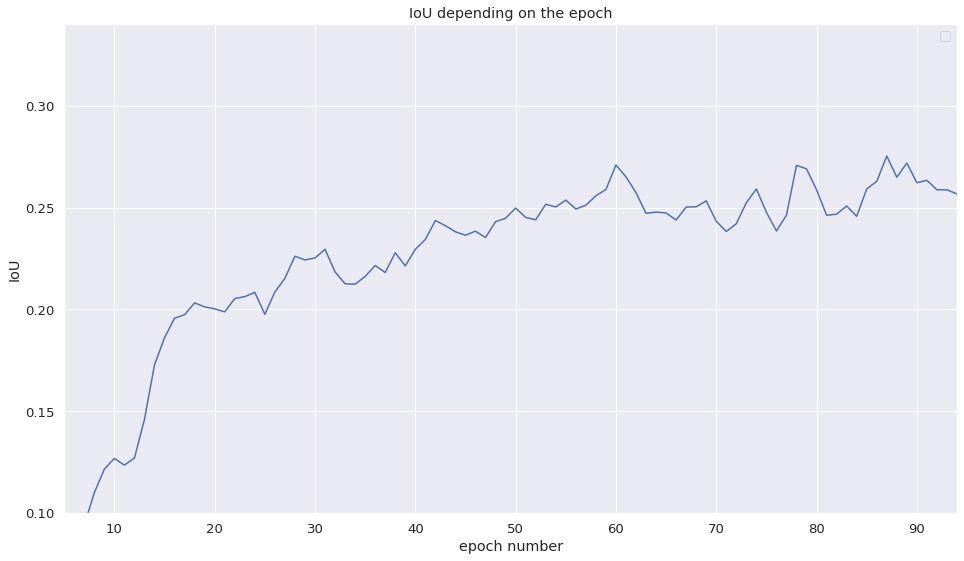

In [ ]:
# Learning curve visualization
with open(MODELS_PATH + str(experiment_number) + '_val_iou', 'rb') as f:
    curve = pickle.load(f)

plt.figure(figsize=(16, 9))
plt.plot(np.arange(len(curve)), curve) #, label=f'iteration {l}')
plt.title('IoU depending on the epoch')
plt.xlabel('epoch number')
plt.legend(loc='best')
plt.ylim(0.1, 0.34)
plt.xlim(5, 94)
_ = plt.ylabel('IoU')

In [35]:
def load_model(exp_number):
    model.load_state_dict(torch.load(MODELS_PATH + str(experiment_number) + '_model'))
    model.eval()
    return model

In [36]:
curr_model = load_model(experiment_number)

In [37]:
MODELS_PATH + str(experiment_number) + '_res'

'drive/MyDrive/hw3data/models/3_res'

In [51]:
import imageio

In [65]:
test_iou = []

In [66]:
def predict(model, img, path):
    logits = model(Variable(torch.FloatTensor(img)).cuda(device)).data.cpu()
    ans = (logits > 0.15).long() * 255
    test_iou.append(calc_iou(ans.numpy(), img.cpu().numpy()))
    ans = ans.squeeze(0).squeeze(0)
    img_uint8 = ans.cpu().detach().numpy().astype(np.uint8)
    imageio.imwrite(path, img_uint8)
    # skimage.io.imsave(path, ans.cpu().detach().numpy())
    
    sns.set(style='white')
    plt.figure(figsize=(8, 4))
    plt.subplot(1, 2, 1)
    plt.imshow(ans)
    plt.subplot(1, 2, 2)
    plt.imshow(np.transpose(img.squeeze(0), [1, 2, 0]))
    plt.show()
    
def make_submit(model, test_data, n_exp=experiment_number):
    dir_name = MODELS_PATH + str(n_exp) + '_res'
    try:
        # Create target Directory
        os.mkdir(dir_name)
        print("Directory " , dir_name ,  " Created ") 
    except FileExistsError:
        print("Directory " , dir_name ,  " already exists")
    
    for i in range(len(test_data)):
        file_name = os.path.basename(test_data.img_files[i])[:-3] + 'png'
        predict(model, test_data[i].unsqueeze(0), os.path.join(dir_name, file_name))

Directory  drive/MyDrive/hw3data/models/3_res  already exists


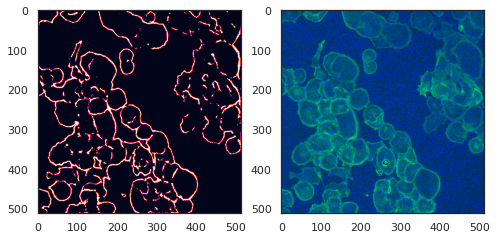

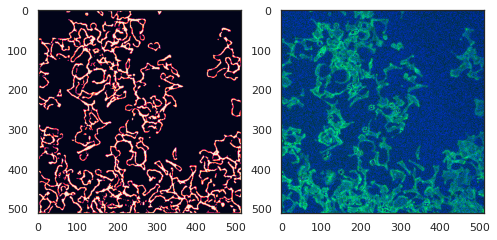

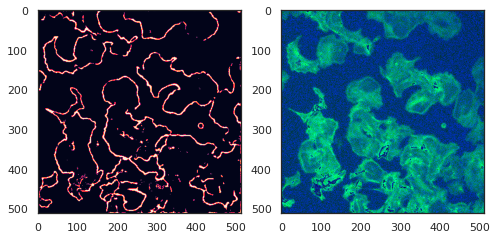

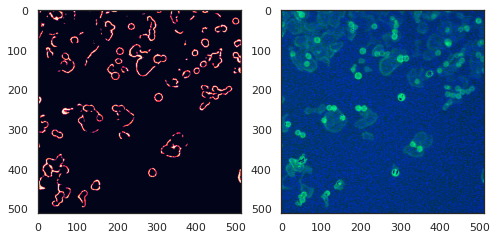

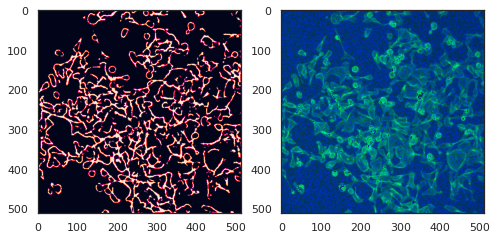

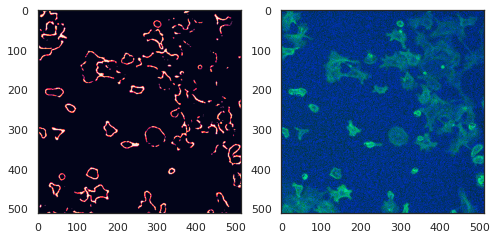

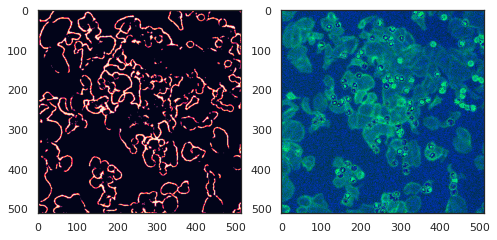

In [67]:
make_submit(curr_model, test_data)

*And I still didn't manage to save image without quality loss...*

*Not surprisingly, trying to calculate iou values with the original cell images, we did not get a very good result...*

In [68]:
test_iou

[0.08706159489963464,
 0.14593539238774544,
 0.07869703084462382,
 0.043528456546302094,
 0.15394247701036978,
 0.04707659327509646,
 0.10335404797964827]